# Two Traveling Salespeople

Name: Cody Lam

I understand that my submission needs to be my own work: yes

Points: 10

## Two-person Version of the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the two tours which collectively visit each of $n$ cities exactly once and return back to the same starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$.

* __State space:__ Each state represents a pair of tours, where the first element of the pair are the cities to visit for the first person and the second element are the cities to visit for the second person. The cities are numbered and the tours can be expressed a pair of vectors $(\pi_1, \pi_2)$ with the order in which the cities are visited. That is, $\pi_i(1)$ is the index of the first city to visit by the $i$th person ($i$ either is 1 or 2), $\pi_i(2)$ the index of the second city to visit by the $i$th person, and so on.

* __Objective function:__ Minimize the maximum tour length for both people. Informally, the cities should be divided up roughly evenly between the two people so that neither one has a tour that is too long.

The optimization problem is to find the optimal pair of tours $\pi_1^*$ and $\pi_2^*$ through the $n$ cities and which return to the start cities of each tour:

  > minimize: $\max(\mathrm{tourlength}(\pi_1), \mathrm{tourlength}(\pi_2))$
  where $\mathrm{tourlength}(\pi_i) = d_{\pi_i(n),\pi_i(1)} + \sum_{j = 1}^{n-1} d_{\pi_i(j),\pi_i(j+1)}$
  >
  > subject to: every city must be visited exactly once


## Helper functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.set_printoptions(precision=2)

np.random.seed(0) # make the results repeatable

In [3]:
def random_tour_pair(n):
    """Create two random tours with n cities"""

    tour = list(range(n))
    np.random.shuffle(tour)

    split_index = np.random.randint(0, n-1)
    tour1 = tour[:split_index]
    tour2 = tour[split_index:]

    return tour1, tour2

random_tour_pair(10)

([2, 8, 4, 9], [1, 6, 7, 3, 0, 5])

In [4]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a
    pairwise Euclidean distance matrix.
    """

    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })

    dist = squareform(pdist(pos))

    return({"pos": pos, "dist": dist})

tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
          x         y
0  0.297535  0.368242
1  0.056713  0.957155
2  0.272656  0.140351
3  0.477665  0.870087
4  0.812169  0.473608
5  0.479977  0.800911
6  0.392785  0.520477
7  0.836079  0.678880
8  0.337396  0.720633
9  0.648172  0.582020
Distance matrix:
          0         1         2         3         4         5         6  \
0  0.000000  0.636250  0.229245  0.533194  0.525310  0.469561  0.179578   
1  0.636250  0.000000  0.844867  0.429862  0.896957  0.451182  0.551028   
2  0.229245  0.844867  0.000000  0.757987  0.634140  0.692330  0.398657   
3  0.533194  0.429862  0.757987  0.000000  0.518737  0.069215  0.359766   
4  0.525310  0.896957  0.634140  0.518737  0.000000  0.466346  0.421995   
5  0.469561  0.451182  0.692330  0.069215  0.466346  0.000000  0.293676   
6  0.179578  0.551028  0.398657  0.359766  0.421995  0.293676  0.000000   
7  0.621712  0.827556  0.779396  0.406227  0.206659  0.376431  0.470745   
8  0.354638  0.367050  0.583882  0.204968  0.535192  0.

In [27]:
def tour_pair_max_length(tsp, tour_pair):
   """Calculate the maximum length of a pair of tours, i.e., the objective function."""

   tour0_len = tour_length(tsp, tour_pair[0])
   tour1_len = tour_length(tsp, tour_pair[1])

   return max(tour0_len, tour1_len)

def tour_length(tsp, tour):
    """Calculate the length of a single tour"""
    # Handle empty tour case
    if not tour:
        return 0

    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()

    tl = 0
    dist = tsp["dist"]

    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]

    tl += dist[tour[-1], tour[0]]

    return(tl)

np.random.seed(0) # make the results repeatable
tour_pair = random_tour_pair(10)
print(f"objective value: {tour_pair_max_length(tsp, tour_pair)}")

objective value: 2.881937519770044


Tour length (red): 1.9
Tour length (blue): 2.88


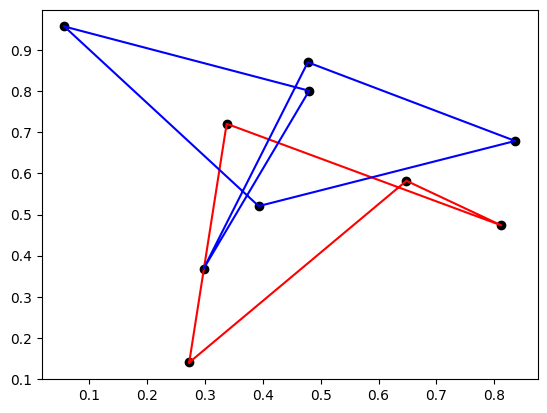

In [26]:
def show_2tsp(tsp, tour_pair = None):
    """display the twoperson traveling salesman problem and a tour pair."""

    pos = tsp["pos"]

    plt.scatter(pos["x"], pos["y"], color='black')

    if tour_pair is not None:
      colors = ['red', 'blue']

      for tour, color in zip(tour_pair, colors):
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()

        print(f"Tour length ({color}): {round(tour_length(tsp, tour), 2)}")
        tour_x_list = [pos.loc[i, 'x'] for i in tour]
        tour_y_list = [pos.loc[i, 'y'] for i in tour]

        # wrap back to start
        tour_x_list.append(tour_x_list[0])
        tour_y_list.append(tour_y_list[0])

        plt.plot(tour_x_list, tour_y_list, color)

    plt.show()

show_2tsp(tsp, tour_pair)

## Steepest-ascent Hill Climbing Search [2 Points]

Come up with reasonable definition for local moves and explain it in text. Implement a steepest-ascent hill climbing strategy. Measure and report the performance of this on 50 random problem instances. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [68]:
"""

"""
# Generate neighboring tour pairs by swapping cities between tours and applying 2-opt moves
def generate_neighbors(tour_pair):
    neighbors = []
    tour1, tour2 = tour_pair

    # Swap a city between the two tours
    for i in range(len(tour1)):
        for j in range(len(tour2)):
            if len(tour1) > 1 and len(tour2) > 1:
                new_tour1, new_tour2 = tour1[:], tour2[:]
                new_tour1[i], new_tour2[j] = new_tour2[j], new_tour1[i] # Where the citys are swapped
                neighbors.append((new_tour1, new_tour2))

    # Apply the two-opt move within each tour
    # def two_opt(tour, other_tour):
    #    # Ensure tour is large enough for 2-opt
    #     if len(tour) > 2:
    #         for i in range(len(tour) - 1):
    #             for j in range(i + 1, len(tour)):
    #                 new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    #                 neighbors.append((new_tour, other_tour))


    # two_opt(tour1, tour2)
    # two_opt(tour2, tour1)

    def two_opt(tour):
       # Ensure tour is large enough for 2-opt
        if len(tour) > 2:
            for i in range(len(tour) - 1):
                for j in range(i + 1, len(tour)):
                    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
                    neighbors.append((new_tour, tour2))
                    neighbors.append((tour1, new_tour))


    two_opt(tour1)
    two_opt(tour2)
    return neighbors

# Steepest-ascent Hill Climbing Search Algorithm
def steepest_ascent_hill(tsp):
    tour_pair = random_tour_pair(len(tsp['pos']))
    best_value = tour_pair_max_length(tsp, tour_pair)
    moves_analyzed = 0

    while True:
        neighbors = generate_neighbors(tour_pair)
        if not neighbors:
          break
        moves_analyzed += len(neighbors) # Keep track of the moves

        # Find the highest-value successor-state (The shortest distance)
        best_neighbor = min(neighbors, key=lambda t: tour_pair_max_length(tsp, t))
        best_neighbor_value = tour_pair_max_length(tsp, best_neighbor)

        # Compare the values and reassign values
        if best_neighbor_value < best_value:
            tour_pair = best_neighbor
            best_value = best_neighbor_value

        # Otherwise return the current and its the best value
        else:
            break

    return best_value, moves_analyzed

# Run experiment on 50 random instances
num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = steepest_ascent_hill(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
print(f"{avg_obj_value}, {avg_moves_analyzed}")

1.5104841362309236, 378.7


## Steepest-ascent Hill Climbing Search with Random Restarts [1 Point]

Modify the code to include random restarts once improvement is no longer possible. For a fixed problem instance, analyze the improvement in the objective function as more restarts are done. Plot the number of restarts on the x axis and the objective function on the y axis.

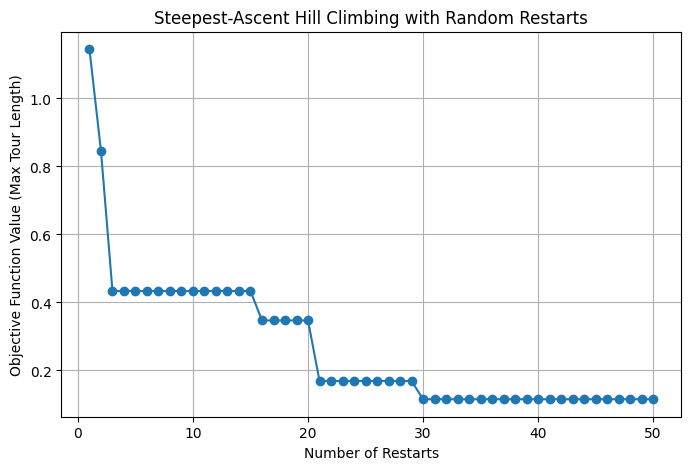

In [71]:
# Code goes here
import matplotlib.pyplot as plt

def hill_climbing_with_restarts(tsp, max_restarts=50):
  best_overall_value = float('inf')
  values_per_restart = []

  for restart in range(max_restarts):
    tour_pair = random_tour_pair(len(tsp["pos"]))
    best_value = tour_pair_max_length(tsp, tour_pair)
    moves_analyzed = 0

    while True:
        neighbors = generate_neighbors(tour_pair)

        if not neighbors:
          break

        moves_analyzed += len(neighbors)
        best_neighbor = min(neighbors, key=lambda t: tour_pair_max_length(tsp, t))
        best_neighbor_value = tour_pair_max_length(tsp, best_neighbor)

        if best_neighbor_value < best_value:
            tour_pair = best_neighbor
            best_value = best_neighbor_value
        else:
            break

    # Keep track of the best objective value so far
    best_overall_value = min(best_overall_value, best_value)
    values_per_restart.append(best_overall_value)

  return values_per_restart

tsp_instance = random_tsp(10)
values_per_restart = hill_climbing_with_restarts(tsp_instance, max_restarts=50)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 51), values_per_restart, marker='o', linestyle='-')
plt.xlabel("Number of Restarts")
plt.ylabel("Objective Function Value (Max Tour Length)")
plt.title("Steepest-Ascent Hill Climbing with Random Restarts")
plt.grid(True)
plt.show()

## Stochastic Hill Climbing [1 Point]

Implement an approach that chooses randomly from among all uphill moves. Measure and report the performance of this on the same 50 random problem instances as was done earlier. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [77]:
# Code goes here
import random

def stochastic_hill_climbing(tsp):
  tour_pair = random_tour_pair(len(tsp['pos']))
  best_value = tour_pair_max_length(tsp, tour_pair)
  moves_analyzed = 0

  while True:
      neighbors = generate_neighbors(tour_pair)
      if not neighbors:
        break

      moves_analyzed += len(neighbors)
      # Filter only the import moves
      improving_moves = [t for t in neighbors if tour_pair_max_length(tsp, t) < best_value]

      if not improving_moves:
          break

      # Choose a random improving move
      tour_pair = random.choice(improving_moves)
      best_value = tour_pair_max_length(tsp, tour_pair)

  return best_value, moves_analyzed

num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = stochastic_hill_climbing(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
avg_obj_value, avg_moves_analyzed


(1.6079014171219894, 737.14)

## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state. Implement this and report the performance of on 50 the same random problem instances. Report the average objective function reached over all problem instances, as well as the average number of local moves analyzed.

In [73]:
"""
In a First-choice hill climbing it generates one random local neighbor at a time and then accept if it has a better
objective function value than the current state.
"""
def first_choice_hill_climbing(tsp, max_attempts=50):
  tour_pair = random_tour_pair(len(tsp['pos']))
  best_value = tour_pair_max_length(tsp, tour_pair)
  moves_analyzed = 0

  for _ in range(max_attempts):
    neighbors = generate_neighbors(tour_pair)

    if not neighbors:
      break

    moves_analyzed += 1 # Only doing one neighbor at a time
    random_neighbor = random.choice(neighbors)
    neighbor_value = tour_pair_max_length(tsp, random_neighbor)

    # Accepts if the random neighbor has a better value than the current state
    if neighbor_value < best_value:
      tour_pair = random_neighbor
      best_value = neighbor_value

  return best_value, moves_analyzed


num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = stochastic_hill_climbing(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
avg_obj_value, avg_moves_analyzed


(1.524821114918324, 833.12)

## Simulated Annealing [1 Point]

Implement an algorithm that uses simulated annealing to solve the problem, as described in the lectures and book (Section 4.1.2). Experiment with hyperparameters like the temperature schedule and thresholds until you find values that work well.

In [94]:
"""
In a simulated annealing for the two-person tsp
"""
import math
def initial_tour_pair(n, new_york_index):
    states = list(range(n))
    states.remove(new_york_index)
    random.shuffle(states)
    mid = len(states) // 2
    tour1 = [new_york_index] + states[:mid] + [new_york_index]
    tour2 = [new_york_index] + states[mid:] + [new_york_index]
    return tour1, tour2

def simulated_annealing(tsp, initial_temperature=10.0, cooling_rate=0.99, min_temperature=0.01, max_iterations=1000, fixed_start_end=None):
    n = len(tsp["dist"])
    tour_pair = initial_tour_pair(n, fixed_start_end) if fixed_start_end is not None else random_tour_pair(n)
    current_value = tour_pair_max_length(tsp, tour_pair)
    best_tour = tour_pair
    best_value = current_value
    temperature = initial_temperature
    moves_analyzed = 0


    for t in range(max_iterations):
      if temperature < min_temperature:
        break

      neighbors = generate_neighbors(tour_pair)
      moves_analyzed += 1

      # Select a random neighbor
      random_neighbor = random.choice(neighbors)
      neighbor_value = tour_pair_max_length(tsp, random_neighbor)

      delta = neighbor_value - current_value

      # Accept the new state based on the Simulated Annealing Probability
      if delta < 0 or math.exp(-delta / temperature) > np.random.rand():
        tour_pair = random_neighbor
        current_value = neighbor_value

        # Check if the best solution is found
        if current_value < best_value:
          best_tour = tour_pair
          best_value = current_value

      # This is the cooling schedule
      temperature *= cooling_rate
      # temperature = initial_temperature / (1 + math.log(1 + t))

    return best_value, moves_analyzed

num_instances = 50
objective_values = []
moves_analyzed_list = []

for _ in range(num_instances):
    tsp_instance = random_tsp(10)
    obj_value, moves_analyzed = simulated_annealing(tsp_instance)
    objective_values.append(obj_value)
    moves_analyzed_list.append(moves_analyzed)

# Compute average performance metrics
avg_obj_value = np.mean(objective_values)
avg_moves_analyzed = np.mean(moves_analyzed_list)

# Display results
avg_obj_value, avg_moves_analyzed

(0.08692438702699042, 688.0)

## Compare Performance [1 Point]

Compare simulated annealing with random restarts and stochastic hill climbing. Analyze which algorithm is better for 10 cities, 20 cities, and 50 cities. To make the comparison fair, try to ensure the time taken for each approach is roughly the same.

For timing you can use the `time` package.

In [12]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.13709068298339844 milliseconds


In [93]:
# Code and results go here
import time
import pandas as pd

def compare_algorithms(city_sizes, num_instances=50):
  results = []

  for n in city_sizes:
    tsp_instance = random_tsp(n)

    # Measure Stochastic Hill Climbing
    start_time = time.time()
    stochastic_results = [stochastic_hill_climbing(tsp_instance) for _ in range(num_instances)]
    stochastic_time = (time.time() - start_time) / num_instances

    # Measure Random Restarts Hilling Climbing
    start_time = time.time()
    restart_results = [hill_climbing_with_restarts(tsp_instance, max_restarts=5) for _ in range(num_instances)]
    restart_time = (time.time() - start_time) / num_instances

    # Measure Simulated Annealing
    start_time = time.time()
    sa_results = [simulated_annealing(tsp_instance) for _ in range(num_instances)]
    sa_time = (time.time() - start_time) / num_instances

    # Computing the average performances
    avg_stochastic_obj = np.mean([res[0] for res in stochastic_results])
    avg_stochastic_moves = np.mean([res[1] for res in stochastic_results])

    avg_restart_obj = np.mean([min(res) for res in restart_results])
    avg_restart_moves = np.mean([len(res) for res in restart_results])

    avg_sa_obj = np.mean([res[0] for res in sa_results])
    avg_sa_moves = np.mean([res[1] for res in sa_results])

    # Compute average values
    results.append({
            "Cities": n,
            "Stochastic Obj": avg_stochastic_obj,
            "Stochastic Moves": avg_stochastic_moves,
            "Stochastic Time (s)": stochastic_time,
            "Restart Obj": avg_restart_obj,
            "Restart Moves": avg_restart_moves,
            "Restart Time (s)": restart_time,
            "Simulated Annealing Obj": avg_sa_obj,
            "Simulated Annealing Moves": avg_sa_moves,
            "Simulated Annealing Time (s)": sa_time,
        })

  return pd.DataFrame(results)

city_sizes = [10, 20, 50]
df_results = compare_algorithms(city_sizes, num_instances=10)

df_results

,Cities,Stochastic Obj,Stochastic Moves,Stochastic Time (s),Restart Obj,Restart Moves,Restart Time (s),Simulated Annealing Obj,Simulated Annealing Moves,Simulated Annealing Time (s)
0,10,2.054524,1153.8,0.006698,0.262460,5.0,0.012140,0.000000,688.0,0.049577
1,20,2.100633,7008.7,0.058461,0.782850,5.0,0.088159,1.227337,688.0,0.398573
2,50,3.868633,127114.6,2.681866,1.174362,5.0,2.779000,6.557339,688.0,10.523778


## Tour US States [3 points]

Take your best performing approach for 50 cities and try to find the minimum objective value for a modified version of the two salesman problem going around the 48 lower US states. The modification is that both tours must start and end in New York. New York is the only state shared between the two tours.

Each state is considered visited if you can get to its centroid and it is assumed straight line distances between centroids based on GPS coordinates is the way we want to measure distances.

Plot the minimum objective value 2-tsp tours that you find in red and blue, like was done before for the randomly generated points. Print the length of the best tours, as well as the list of indices corresponding to states (Louisiana=0, Maryland=1, ... , see code below).

Loaded from states.pkl


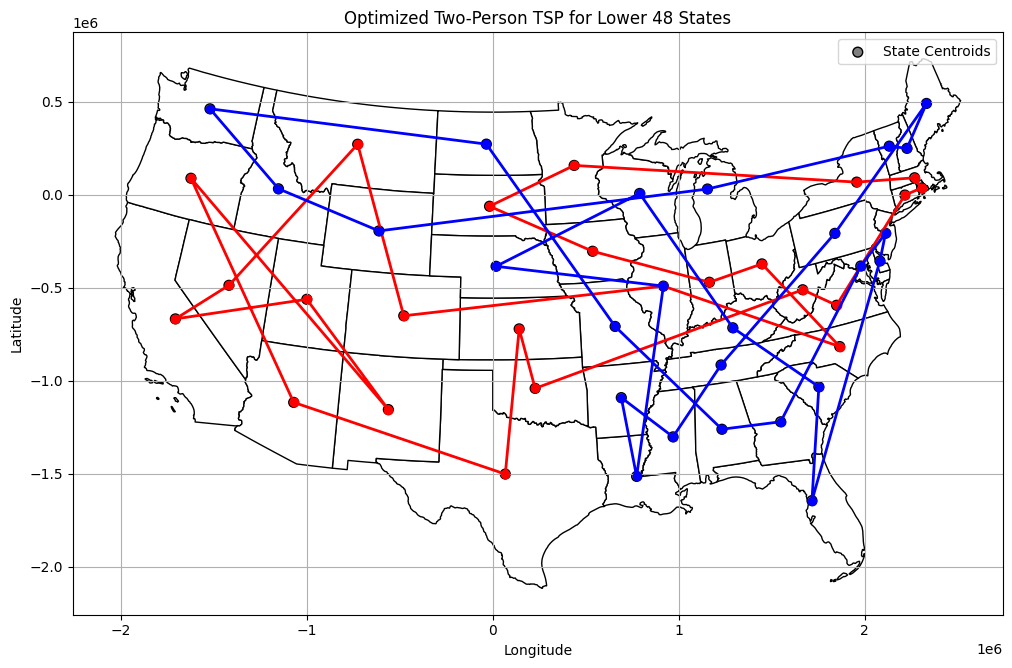

Best tour length (Tour 1): 18568135.089318447
Best tour length (Tour 2): 18667116.84857268
Max Tour Length (Objective Value): 18667116.84857268
Tour 1 States: ['Illinois', 'Colorado', 'Montana', 'Nevada', 'California', 'Utah', 'New Mexico', 'Oregon', 'Arizona', 'Texas', 'Kansas', 'Oklahoma', 'West Virginia', 'Virginia', 'Connecticut', 'Rhode Island', 'Massachusetts', 'New York', 'Minnesota', 'South Dakota', 'Iowa', 'Indiana', 'Ohio', 'North Carolina', 'Illinois']
Tour 2 States: ['Illinois', 'Nebraska', 'Wisconsin', 'Kentucky', 'South Carolina', 'Florida', 'Delaware', 'New Jersey', 'Maryland', 'Georgia', 'Alabama', 'Missouri', 'North Dakota', 'Washington', 'Idaho', 'Wyoming', 'Michigan', 'Vermont', 'New Hampshire', 'Maine', 'Pennsylvania', 'Tennessee', 'Mississippi', 'Arkansas', 'Louisiana', 'Illinois']


In [104]:
import geopandas as gpd

def get_state_centroids():
    # load pickled data from states.pkl if it exists
    try:
        states = pd.read_pickle('states.pkl')
        print('Loaded from states.pkl')
    except:
        states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip')

        # pickle (save) the data to states.pkl so we don't need to download in the future
        states.to_pickle('states.pkl')

        print('Downloaded data and saved to states.pkl')

    # Filter out Alaska, Hawaii, and territories
    contiguous_usa = states[~states['STUSPS'].isin(['AK', 'HI', 'PR', 'GU', 'VI', 'MP', 'AS', 'DC'])]

    # Get centroid data
    contiguous_usa = contiguous_usa.to_crs(epsg=2163)
    centroids = contiguous_usa.geometry.centroid
    contiguous_usa['centroid_lon'] = centroids.x
    contiguous_usa['centroid_lat'] = centroids.y

    # Create DataFrame with state names and coordinates
    states_df = pd.DataFrame({
        "State": contiguous_usa['NAME'],
        "x": centroids.x,
        "y": centroids.y
    })

    # Create tuples (state name, x-coordinate, y-coordinate)
    # state_tuples = list(zip(contiguous_usa['NAME'], centroids.x, centroids.y))
    dist_matrix = squareform(pdist(states_df[['x', 'y']]))

    # return contiguous_usa, state_tuples
    return states_df, dist_matrix

# Load the state centroids and distance matrix
states_df, dist_matrix = get_state_centroids()

# Get New York's index
new_york_index = states_df[states_df['State'] == 'New York'].index[0]
def random_tour_pair(n, new_york_index):
    states = list(range(n))
    states.remove(new_york_index)  # Remove NY from being randomly placed
    random.shuffle(states)
    mid = len(states) // 2
    tour1 = [new_york_index] + states[:mid] + [new_york_index]
    tour2 = [new_york_index] + states[mid:] + [new_york_index]
    return tour1, tour2

# Function to compute tour length
def tour_length(dist_matrix, tour):
    return sum(dist_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1))

# Function to calculate max tour length
def tour_pair_max_length(dist_matrix, tour_pair):
    return max(tour_length(dist_matrix, tour_pair[0]), tour_length(dist_matrix, tour_pair[1]))

# Generate neighbors by swapping cities between tours (ensuring NY stays fixed)
def generate_neighbors(tour_pair, new_york_index):
    neighbors = []
    tour1, tour2 = tour_pair[0][1:-1], tour_pair[1][1:-1]  # Remove NY for swapping

    for i in range(len(tour1)):
        for j in range(len(tour2)):
            new_tour1, new_tour2 = tour1[:], tour2[:]
            new_tour1[i], new_tour2[j] = new_tour2[j], new_tour1[i]
            neighbors.append(([new_york_index] + new_tour1 + [new_york_index],
                              [new_york_index] + new_tour2 + [new_york_index]))

    return neighbors

def simulated_annealing(tsp, initial_temperature=1000, cooling_rate=0.995, min_temperature=1, max_iterations=10000, fixed_start_end=None):
    """
    Simulated Annealing for the Two-Person TSP.
    If `fixed_start_end` is provided, ensures both tours start and end at that city.
    """
    n = len(tsp["dist"])

    # Use modified `random_tour_pair()` if NY is fixed
    tour_pair = random_tour_pair(n, fixed_start_end) if fixed_start_end is not None else random_tour_pair(n, None)

    current_value = tour_pair_max_length(tsp["dist"], tour_pair)
    best_tour = tour_pair
    best_value = current_value
    temperature = initial_temperature

    for _ in range(max_iterations):
        if temperature < min_temperature:
            break

        neighbors = generate_neighbors(tour_pair, fixed_start_end) if fixed_start_end is not None else generate_neighbors(tour_pair, None)
        if not neighbors:
            continue

        random_neighbor = random.choice(neighbors)
        neighbor_value = tour_pair_max_length(tsp["dist"], random_neighbor)

        delta = neighbor_value - current_value

        if delta < 0 or math.exp(-delta / temperature) > np.random.rand():
            tour_pair = random_neighbor
            current_value = neighbor_value

            if current_value < best_value:
                best_tour = tour_pair
                best_value = current_value

        temperature *= cooling_rate

    return best_tour, best_value

# Run Simulated Annealing on the US States 2-TSP with **your original function**
best_tour, best_value = simulated_annealing(
    {"dist": dist_matrix},  # Pass the state distance matrix
    fixed_start_end=new_york_index  # Ensure New York is fixed as start/end
)

def plot_optimized_2tsp(states_df, best_tour):
    """
    Plots the best Two-Person TSP solution on the USA map.
    Tour 1 = Red
    Tour 2 = Blue
    """
    # Load USA shapefile and filter for contiguous states
    usa_map = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip')
    contiguous_usa = usa_map[~usa_map['STUSPS'].isin(['AK', 'HI', 'PR', 'GU', 'VI', 'MP', 'AS', 'DC'])]
    contiguous_usa = contiguous_usa.to_crs(epsg=2163)  # Match CRS with centroids

    # Plot the USA state outlines
    fig, ax = plt.subplots(figsize=(12, 8))
    contiguous_usa.plot(ax=ax, color='white', edgecolor='black', linewidth=1)

    # Plot the two TSP tours
    colors = ['red', 'blue']
    for tour, color in zip(best_tour, colors):
        tour_x = [states_df.iloc[i]["x"] for i in tour]
        tour_y = [states_df.iloc[i]["y"] for i in tour]

        # Wrap back to New York
        plt.plot(tour_x, tour_y, color=color, linewidth=2, marker='o')

    # Plot state centroids
    colors = ['red' if state == 'New York' else 'grey' for state in states_df['State']]
    plt.scatter(states_df["x"], states_df["y"], color=colors, edgecolors='black', s=50, label="State Centroids")

    # Formatting
    plt.title("Optimized Two-Person TSP for Lower 48 States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)

    plt.show()

# Run Simulated Annealing on the US States 2-TSP with your original function
best_tour, best_value = simulated_annealing(
    {"dist": dist_matrix},  # Pass the state distance matrix
    fixed_start_end=new_york_index  # Ensure New York is fixed as start/end
)

# Extract tour lengths
tour1_length = tour_length(dist_matrix, best_tour[0])
tour2_length = tour_length(dist_matrix, best_tour[1])

# Plot the optimized solution
plot_optimized_2tsp(states_df, best_tour)

# Print Results
print(f"Best tour length (Tour 1): {tour1_length}")
print(f"Best tour length (Tour 2): {tour2_length}")
print(f"Max Tour Length (Objective Value): {best_value}")
print(f"Tour 1 States: {[states_df.iloc[i]['State'] for i in best_tour[0]]}")
print(f"Tour 2 States: {[states_df.iloc[i]['State'] for i in best_tour[1]]}")



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
